# Fine tuning classification with OpenAI

We will fine-tune some OpenAI classifier to classify the number of stars a reviewer will give a review of an app

In [13]:
# Importing necessary libraries
import pandas as pd  # Used for data manipulation and analysis
from openai import OpenAI  # OpenAI's API for accessing its AI models
import os  # Provides functions to interact with the operating system
from datasets import load_dataset  # Library to load and preprocess datasets
import random  # Provides functions for generating random numbers
import math  # Provides mathematical functions
import matplotlib.pyplot as plt
import json
import seaborn as sns  # Seaborn provides a higher-level interface for styling plots
import numpy as np
from tqdm.auto import tqdm
import math
import base64
import csv
import json

# Setting the style to a modern look
sns.set_style("whitegrid")

# Defining a constant SEED for reproducibility in random operations
SEED = 42

# Setting the seed for the random library to ensure consistent results
random.seed(SEED)


In [14]:
client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

In [15]:
# 'star' is a column in our dataset and we want to convert it to a ClassLabel column
# so we can stratify our samples.

# Importing the ClassLabel module to represent categorical class labels
from datasets import ClassLabel

# Loading the 'app_reviews' dataset's training split into the 'dataset' variable
dataset = load_dataset('app_reviews', split='train')

# Converting the 'star' column in our dataset to a ClassLabel type
# This allows for categorical representation and easier handling of classes
dataset = dataset.class_encode_column('star')

# Displaying the dataset to see the changes
dataset


Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

In [16]:
# Splitting the dataset into a training set and a test set.
# We reserve 20% of the data for testing and use stratification on the 'star' column
# to ensure both sets have an equal distribution of each star category.
dataset = dataset.train_test_split(test_size=0.2, seed=SEED, stratify_by_column='star')

# Now, we further split our training dataset to reserve 25% of it for validation.
# Again, we stratify by the 'star' column to keep the distribution consistent.
df = dataset['train'].train_test_split(test_size=.25, seed=SEED, stratify_by_column='star')

# Assigning the split datasets to their respective keys:
# - The remaining 75% of our initial training data becomes the new training dataset.
dataset['train'] = df['train']

# - The 25% split from our initial training data becomes the validation dataset.
dataset['val'] = df['test']

# Displaying the dataset to see the distribution across train, test, and validation sets.
dataset


DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

In [18]:
# convert to pandas dataframe
training_df = pd.DataFrame(dataset['train'])

training_df[['review', 'star']].head(10)

,review,star
0,Nice😉,4
1,Google play service Just one ward its amazing ...,4
2,Mr Perfect,0
3,Does not work with Tmobile S4 If you try to in...,0
4,Ok,2
5,Say App Ka nam to the other than a few months,4
6,Owk,4
7,Coc,4
8,Not working bad,0
9,After downloading this app my phone slowed do...,0


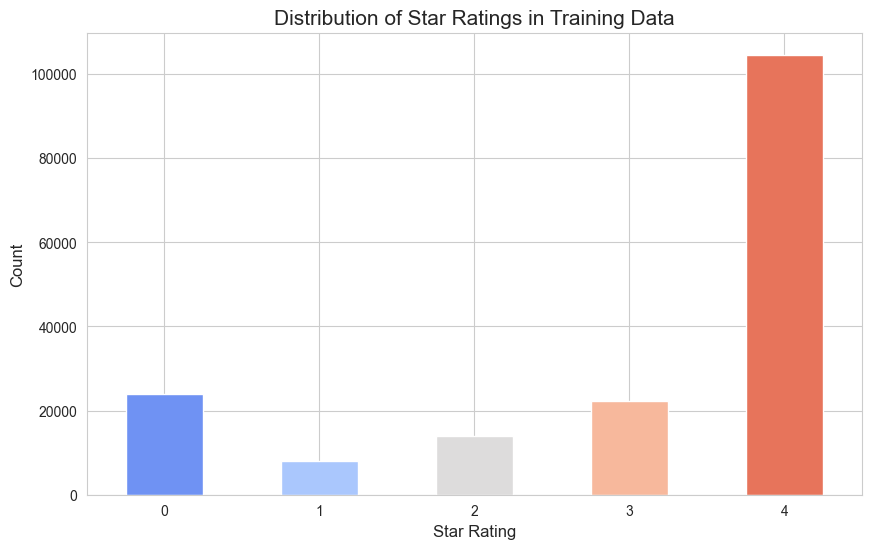

In [9]:
# Counting the number of occurrences for each 'star' value, sorting by index
star_counts = training_df['star'].value_counts().sort_index()

# Creating the bar plot to show distribution of star ratings given
plt.figure(figsize=(10, 6))  # Setting a suitable figure size for better visibility
star_counts.plot(kind='bar', color=sns.color_palette("coolwarm", len(star_counts)))

# Adding titles and labels for clarity
plt.title('Distribution of Star Ratings in Training Data', fontsize=15)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)  # Ensure the x-axis labels are horizontal for better readability

# Displaying the chart
plt.show()


In [10]:
test_df = pd.DataFrame(dataset['test'])
val_df = pd.DataFrame(dataset['val'])

# Star prediction (sentiment)

In [72]:
# Creating the 'prompt' column in each dataset (training, validation, and test) by adding a separator '###\n' to the 'review' column.
# This separator is often used in fine-tuning to signal where the prompt ends and the expected output begins.
training_df['prompt'] = training_df['review'] + '\n###\n'
val_df['prompt'] = val_df['review'] + '\n###\n'
test_df['prompt'] = test_df['review'] + '\n###\n'

# Converting the 'star' column in each dataset to a string format and storing it in the 'completion' column.
# The 'completion' column will be used as the target variable for sentiment analysis.
training_df['completion'] = training_df['star'].astype(str)  # for sentiment
val_df['completion'] = val_df['star'].astype(str)  # for sentiment
test_df['completion'] = test_df['star'].astype(str)  # for sentiment

# Creating a training dataset in JSONL format after dropping duplicates based on the 'prompt' column.
# Random sampling ensures the data is shuffled.
training_df.sample(
    len(training_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-train-sentiment-random.jsonl", orient='records', lines=True
)

# Creating a validation dataset in JSONL format after dropping duplicates based on the 'prompt' column.
val_df.sample(
    len(val_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-val-sentiment-random.jsonl", orient='records', lines=True
)

# Creating a test dataset in JSONL format after dropping duplicates based on the 'prompt' column.
test_df.sample(
    len(test_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-test-sentiment-random.jsonl", orient='records', lines=True
)

In [12]:
training_df.head(2)

,package_name,review,date,star,prompt,completion
0,org.ppsspp.ppsspp,Nice😉,March 09 2017,4,Nice😉\n###\n,4
1,com.google.android.gms,Google play service Just one ward its amazing ...,December 18 2016,4,Google play service Just one ward its amazing ...,4


In [13]:
def get_data_dict(row, system=''):
    return {
        "messages": [
            {"role": "system", "content": system},
            {"role": "user", "content": row['review']},
            {"role": "assistant", "content": str(row['star'])}
        ]
    }

In [14]:
# export 3.5 prompts with no system prompt
with open(f'app-review-full-train-sentiment-random-3.5.jsonl', 'w') as f:
    for index, row in training_df.iterrows():
        json_str = json.dumps(get_data_dict(row))  # Create a dictionary for each row
        f.write(json_str + '\n')  # Write JSON string to a file

with open(f'app-review-full-test-sentiment-random-3.5.jsonl', 'w') as f:
    for index, row in test_df.iterrows():
        json_str = json.dumps(get_data_dict(row))  # Create a dictionary for each row
        f.write(json_str + '\n')  # Write JSON string to a file

with open(f'app-review-full-val-sentiment-random-3.5.jsonl', 'w') as f:
    for index, row in val_df.iterrows():
        json_str = json.dumps(get_data_dict(row))  # Create a dictionary for each row
        f.write(json_str + '\n')  # Write JSON string to a file

In [145]:
system_prompt = 'You predict star ratings from 0-4 where 0 is the worst rating and 4 is the best'

In [16]:
# export 3.5 prompts with a system prompt
# 22 extra tokens PER example
with open(f'app-review-full-train-sentiment-random-3.5-system.jsonl', 'w') as f:
    for index, row in training_df.iterrows():
        json_str = json.dumps(get_data_dict(row, system=system_prompt))  # Create a dictionary for each row
        f.write(json_str + '\n')  # Write JSON string to a file

with open(f'app-review-full-test-sentiment-random-3.5-system.jsonl', 'w') as f:
    for index, row in test_df.iterrows():
        json_str = json.dumps(get_data_dict(row, system=system_prompt))  # Create a dictionary for each row
        f.write(json_str + '\n')  # Write JSON string to a file

with open(f'app-review-full-val-sentiment-random-3.5-system.jsonl', 'w') as f:
    for index, row in val_df.iterrows():
        json_str = json.dumps(get_data_dict(row, system=system_prompt))  # Create a dictionary for each row
        f.write(json_str + '\n')  # Write JSON string to a file

In [17]:
print(training_df['prompt'].iloc[0])

Nice😉
###



In [18]:
training_df['star'].iloc[0]

4

# Using OpenAI's Fine-tuning API

In [19]:
# reminder of what this data looks like
json.loads(open("app-review-full-train-sentiment-random.jsonl", "rb").readlines()[0])

{'prompt': "Fantastic App This app is fantastic regardless! I would love some features like lock screen options  etc. But either way you did a great job. I was using Nils previously and stopped and really didn't find another one I liked until now but I have to try it out and see how it worked in my everyday use.\n###\n",
 'completion': '4'}

In [20]:
client

In [23]:
# Creating a file object for the training dataset with OpenAI's API.
# The 'file' parameter specifies the path to the training data in JSONL format.
# The 'purpose' is set to 'fine-tune', indicating the file's intended use.
no_system_training_file = client.files.create(
  file=open("app-review-full-train-sentiment-random.jsonl", "rb"),
  purpose='fine-tune'
)

# Creating a file object for the validation dataset with OpenAI's API.
no_system_val_file = client.files.create(
  file=open("app-review-full-val-sentiment-random.jsonl", "rb"),
  purpose='fine-tune'
)


In [24]:
no_system_training_file

FileObject(id='file-wbvOnNScdsHSQaUmT75XAm0n', bytes=15979754, created_at=1715867493, filename='app-review-full-train-sentiment-random.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [25]:
# Initiating the fine-tuning process with OpenAI's API.

# The `client.fine_tuning.jobs.create method is used to start the training.
# Parameters include:
# - `training_file`: The ID of the previously uploaded training dataset file.
# - `validation_file`: The ID of the previously uploaded validation dataset file.
# - `model`: The base model to be fine-tuned. In this case, "babbage-002" is chosen.
# - `hyperparameters`: Dictionary containing training hyperparameters. Here, we specify the number of epochs as 1.
no_system_babbage_job = client.fine_tuning.jobs.create(
    training_file=no_system_training_file.id,
    validation_file=no_system_val_file.id,
    model="babbage-002",
    hyperparameters={'n_epochs': 1}
)

In [60]:
# Retrieving details of an ongoing or completed fine-tuning job using OpenAI's API.

# The `client.fine_tuning.retrieve.retrieve` method fetches the job details based on its ID.
# This can be used to monitor the progress, status, or retrieve results of the training job.
job = client.fine_tuning.jobs.retrieve(no_system_babbage_job.id)


In [61]:
job

FineTuningJob(id='ftjob-YKpH6oQ2y4h8eixygIkbfpKl', created_at=1715867501, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:babbage-002:personal::9PVvOEA2', finished_at=1715867945, hyperparameters=Hyperparameters(n_epochs=1, batch_size=90, learning_rate_multiplier=16), model='babbage-002', object='fine_tuning.job', organization_id='org-azQm6jrJ3FSBpJAwYcgxQxGu', result_files=['file-FfRpgmIKmvJup3F1Vlk1pLEO'], status='succeeded', trained_tokens=2833557, training_file='file-wbvOnNScdsHSQaUmT75XAm0n', validation_file='file-RADPtyc4aeYwp37GthGpAhuO', user_provided_suffix=None, seed=410307512, estimated_finish=None, integrations=[])

In [62]:
job.id

'ftjob-YKpH6oQ2y4h8eixygIkbfpKl'

In [114]:
for event in client.fine_tuning.jobs.list_events(fine_tuning_job_id=no_system_babbage_job.id):
    print(event)
    print('---')

FineTuningJobEvent(id='ftevent-7OmV2Wu3yPTIycjudw7yItNF', created_at=1715867949, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message')
---
FineTuningJobEvent(id='ftevent-g2ssTaCuEkDsxU6FkxAJKHhk', created_at=1715867946, level='info', message='New fine-tuned model created: ft:babbage-002:personal::9PVvOEA2', object='fine_tuning.job.event', data={}, type='message')
---
FineTuningJobEvent(id='ftevent-jo7oF0ATy3hX6azLMqrzg9U4', created_at=1715867946, level='info', message='Checkpoint created at step 1500 with Snapshot ID: ft:babbage-002:personal::9PVvNOWi:ckpt-step-1500', object='fine_tuning.job.event', data={}, type='message')
---
FineTuningJobEvent(id='ftevent-pKU8FZNjsm9fr9GdEgLwIhdd', created_at=1715867941, level='info', message='Step 1501/1501: training loss=1.03', object='fine_tuning.job.event', data={'step': 1501, 'train_loss': 1.027484655380249, 'total_steps': 1501, 'train_mean_token_accuracy': 0.5909090638160706}, type

In [34]:
if len(job.result_files):
    print(job.result_files)

['file-FfRpgmIKmvJup3F1Vlk1pLEO']


In [35]:
job

FineTuningJob(id='ftjob-YKpH6oQ2y4h8eixygIkbfpKl', created_at=1715867501, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:babbage-002:personal::9PVvOEA2', finished_at=1715867945, hyperparameters=Hyperparameters(n_epochs=1, batch_size=90, learning_rate_multiplier=16), model='babbage-002', object='fine_tuning.job', organization_id='org-azQm6jrJ3FSBpJAwYcgxQxGu', result_files=['file-FfRpgmIKmvJup3F1Vlk1pLEO'], status='succeeded', trained_tokens=2833557, training_file='file-wbvOnNScdsHSQaUmT75XAm0n', validation_file='file-RADPtyc4aeYwp37GthGpAhuO', user_provided_suffix=None, seed=410307512, estimated_finish=None, integrations=[])

In [63]:
# Downloading the results of the completed fine-tuning job using OpenAI's API.

# The `client.files.retrieve_content` method is used to fetch the result files.
# `job.result_files[0]` gets the ID of the first result file associated with the job.
results = client.files.content(job.result_files[0])

# Base64 string (example, replace with your actual string)
base64_string = results.read()

# Decode the base64 string
decoded_bytes = base64.b64decode(base64_string)
decoded_str = decoded_bytes.decode('utf-8')

# Assuming the content is in CSV format, you can write it to a CSV file directly
with open('results.csv', 'w') as file:
    file.write(decoded_str)

print("CSV file created successfully.")


CSV file created successfully.


In [64]:
results_df = pd.read_csv('results.csv')

results_df.head()

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,2.35323,0.32222,NaN,NaN
1,2,2.06554,0.40000,NaN,NaN
2,3,2.27685,0.42222,NaN,NaN
3,4,2.49178,0.40000,NaN,NaN
4,5,2.35188,0.37778,NaN,NaN


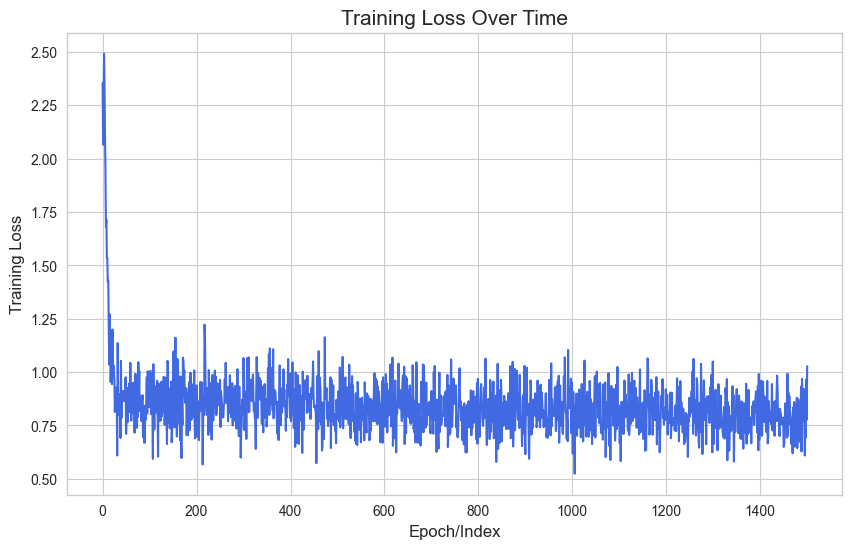

In [65]:
# Plotting the 'valid_loss' values from the 'results_df' DataFrame.
# We drop any NaN values to ensure a smooth plot.
plt.figure(figsize=(10, 6))  # Setting a suitable figure size for better visibility
results_df['train_loss'].dropna().plot(color="royalblue")

# Adding titles and labels for clarity
plt.title('Training Loss Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)

# Displaying the plot
plt.savefig('2.png', dpi=500)

plt.show()


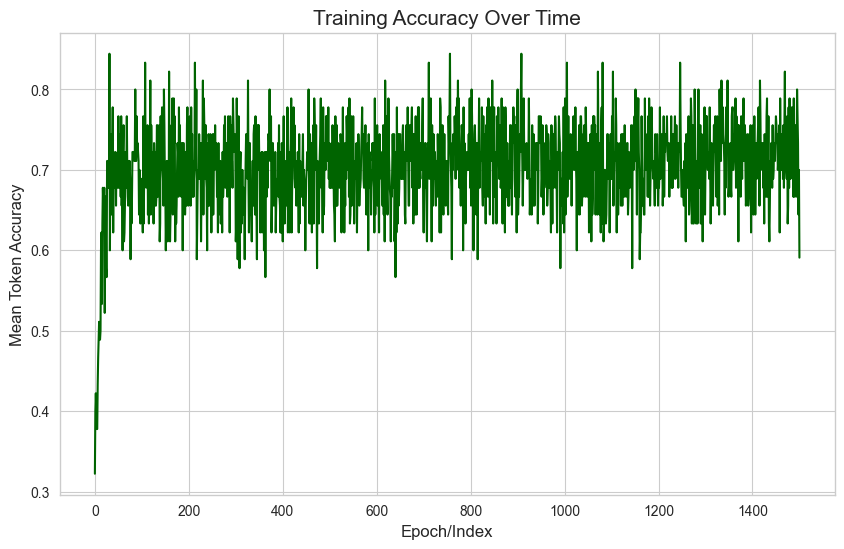

In [66]:
# Plotting the 'valid_mean_token_accuracy' values from the 'results_df' DataFrame.
# We omit any NaN values to ensure a smooth, continuous plot.
plt.figure(figsize=(10, 6))  # Designating an optimal figure size for better clarity
results_df['train_accuracy'].dropna().plot(color="darkgreen")

# Adding titles and labels for clarity
plt.title('Training Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Mean Token Accuracy', fontsize=12)

# Showcasing the plot
plt.savefig('1.png', dpi=500)
plt.show()


# Further fine-tune our Babbage model for 3 more epochs

In [121]:
job.fine_tuned_model

'ft:babbage-002:personal::9PVvOEA2'

In [68]:
no_system_babbage_more_epoch_job = client.fine_tuning.jobs.create(
    training_file=no_system_training_file.id,
    validation_file=no_system_val_file.id,
    model=job.fine_tuned_model,
    hyperparameters={'n_epochs': 3}
)

In [22]:
no_system_babbage_more_epoch_job.id

'ftjob-FycOYNDnn4jRNOYtzP6qIzJt'

In [57]:
job = client.fine_tuning.jobs.retrieve(no_system_babbage_more_epoch_job.id)
results_df = None
if len(job.result_files):
    results = client.files.content(job.result_files[0])
    # Base64 string (example, replace with your actual string)
    base64_string = results.read()
    
    # Decode the base64 string
    decoded_bytes = base64.b64decode(base64_string)
    decoded_str = decoded_bytes.decode('utf-8')
    
    # Assuming the content is in CSV format, you can write it to a CSV file directly
    with open('results.csv', 'w') as file:
        file.write(decoded_str)
results_df = pd.read_csv('results.csv')


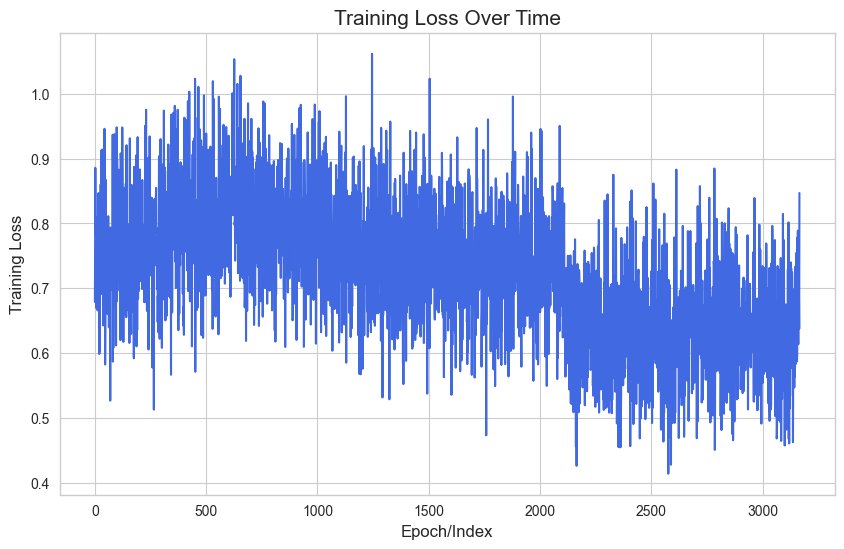

In [58]:
# Plotting the 'valid_loss' values from the 'results_df' DataFrame.
# We drop any NaN values to ensure a smooth plot.
plt.figure(figsize=(10, 6))  # Setting a suitable figure size for better visibility
results_df['train_loss'].dropna().plot(color="royalblue")

# Adding titles and labels for clarity
plt.title('Training Loss Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)

# Displaying the plot
plt.savefig('4.png', dpi=500)

plt.show()


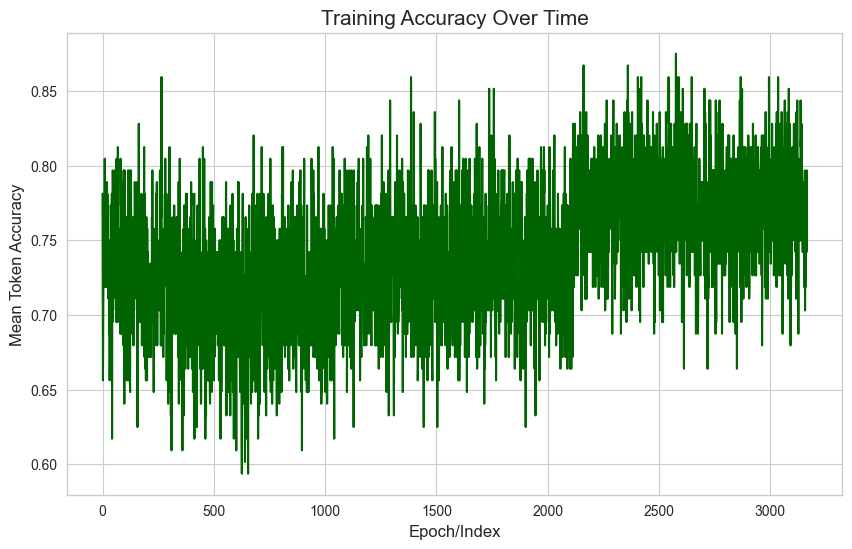

In [53]:
# Plotting the 'valid_mean_token_accuracy' values from the 'results_df' DataFrame.
# We omit any NaN values to ensure a smooth, continuous plot.
plt.figure(figsize=(10, 6))  # Designating an optimal figure size for better clarity
results_df['train_accuracy'].dropna().plot(color="darkgreen")

# Adding titles and labels for clarity
plt.title('Training Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Mean Token Accuracy', fontsize=12)

# Showcasing the plot
plt.savefig('3.png', dpi=500)

plt.show()


In [ ]:
# basically no change in performance..

In [ ]:
# in the legacy API, you had to shuffle the data yourself before uploading it or else you were 
#  subject to severely worse performance from the fine-tuning

# Let's see if this is still true..

In [304]:
# Upload a new file that is specifically sorted by star
ordered_training_file = client.files.create(
  file=open("app-review-full-train-sentiment-ordered.jsonl", "rb"),
  purpose='fine-tune'
)

In [305]:
job = client.fine_tuning.jobs.create(
    training_file=ordered_training_file.id,
    validation_file=val_file.id,
    model='babbage-002',
    hyperparameters={'n_epochs': 1}
)


In [608]:
job.id

'ftjob-qdXc2PVcEl3ENr9b1YemfGEr'

In [379]:
job = client.fine_tuning.jobs.retrieve(job.id)
print(job)
results_df = None
if len(job.result_files):
    print(job.result_files)
    results = client.files.retrieve_content(job.result_files[0])
    with open('results.csv', 'w') as f:
        f.write(results)
    results_df = pd.read_csv('results.csv')

results_df.head()

{
  "object": "fine_tuning.job",
  "id": "ftjob-qdXc2PVcEl3ENr9b1YemfGEr",
  "model": "babbage-002",
  "created_at": 1698422344,
  "finished_at": 1698428920,
  "fine_tuned_model": "ft:babbage-002:personal::8ELEnbVw",
  "organization_id": "org-azQm6jrJ3FSBpJAwYcgxQxGu",
  "result_files": [
    "file-mUr8uYRZGeAjt5CTrHpEwEta"
  ],
  "status": "succeeded",
  "validation_file": "file-yF5vsOt3IMOhJs2jFeK46nWo",
  "training_file": "file-JRecjWOWPenIwB6A5zEhmWz2",
  "hyperparameters": {
    "n_epochs": 1
  },
  "trained_tokens": 2833557,
  "error": null
}
['file-mUr8uYRZGeAjt5CTrHpEwEta']


,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,2.20046,0.51111,2.09622,0.47778
1,2,2.57506,0.25556,NaN,NaN
2,3,2.10734,0.47778,NaN,NaN
3,4,2.60895,0.31111,NaN,NaN
4,5,2.28541,0.41111,NaN,NaN


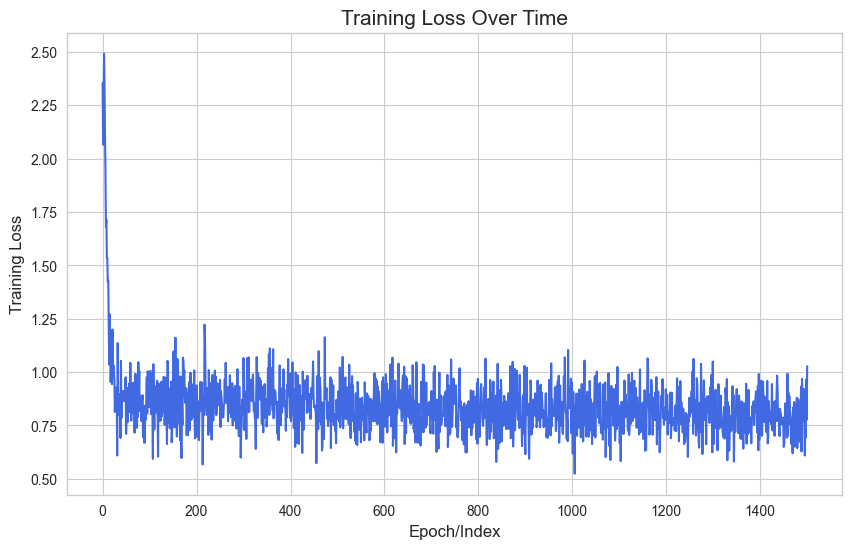

In [45]:
# Plotting the 'valid_loss' values from the 'results_df' DataFrame.
# We drop any NaN values to ensure a smooth plot.
plt.figure(figsize=(10, 6))  # Setting a suitable figure size for better visibility
results_df['train_loss'].dropna().plot(color="royalblue")

# Adding titles and labels for clarity
plt.title('Training Loss Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)

# Displaying the plot
plt.show()


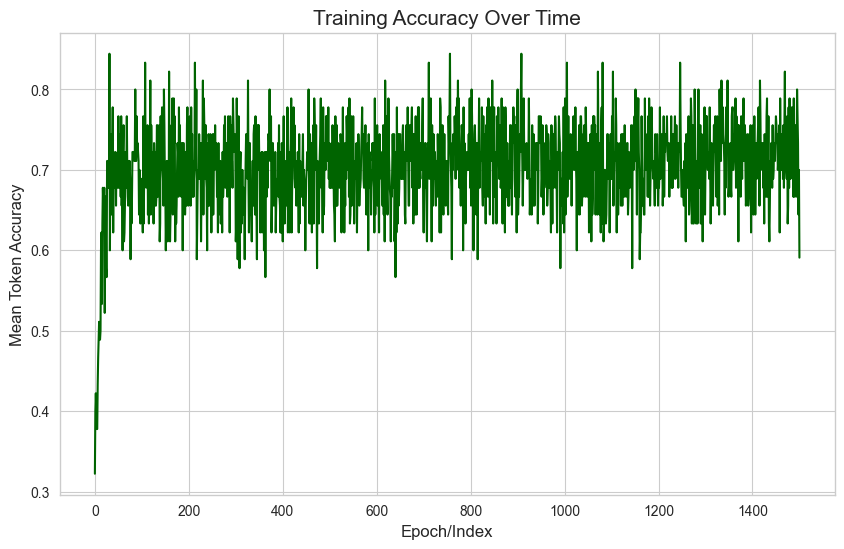

In [44]:
# Plotting the 'valid_mean_token_accuracy' values from the 'results_df' DataFrame.
# We omit any NaN values to ensure a smooth, continuous plot.
plt.figure(figsize=(10, 6))  # Designating an optimal figure size for better clarity
results_df['train_accuracy'].dropna().plot(color="darkgreen")

# Adding titles and labels for clarity
plt.title('Training Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Mean Token Accuracy', fontsize=12)

# Showcasing the plot
plt.show()


In [ ]:
# looks like about the same result. The legacy API showed a huge difference in performance but the new version
#  seems to be shuffling the data in the backend even though I can't find reference to this behavior in their documentation.
#  We love that though!

# 3.5 training - first with no system prompt

In [35]:
# reminder of what this data looks like
json.loads(open("app-review-full-train-sentiment-random-3.5.jsonl", "rb").readlines()[0])

{'messages': [{'role': 'system', 'content': ''},
  {'role': 'user', 'content': 'Nice😉'},
  {'role': 'assistant', 'content': '4'}]}

In [239]:
# Upload our GPT 3.5 training data
no_system_training_file_3_5 = client.files.create(
  file=open("app-review-full-train-sentiment-random-3.5.jsonl", "rb"),
  purpose='fine-tune'
)

# Creating a file object for the validation dataset with OpenAI's API.
no_system_val_file_3_5 = client.files.create(
  file=open("app-review-full-val-sentiment-random-3.5.jsonl", "rb"),
  purpose='fine-tune'
)

In [240]:
gpt_3_5_no_system_job = client.fine_tuning.jobs.create(
    training_file=no_system_training_file_3_5.id,
    validation_file=no_system_val_file_3_5.id,
    model='gpt-3.5-turbo',
    hyperparameters={'n_epochs': 1}
)


In [238]:
gpt_3_5_no_system_job.id

'ftjob-zYEPB5RONCrCzgGW1P8UhI1U'

In [244]:
job = client.fine_tuning.jobs.retrieve(gpt_3_5_no_system_job.id)
results_df = None
if len(job.result_files):
    print(job.result_files)
    results = client.files.content(job.result_files[0])
        
    # Base64 string (example, replace with your actual string)
    base64_string = results.read()
    
    # Decode the base64 string
    decoded_bytes = base64.b64decode(base64_string)
    decoded_str = decoded_bytes.decode('utf-8')
    
    # Assuming the content is in CSV format, you can write it to a CSV file directly
    with open('results.csv', 'w') as file:
        file.write(decoded_str)
else:
    raise ValueError('Not Done Yet')
results_df = pd.read_csv('results.csv')


['file-xBdkOt6992a0SlzS8k0JMTlm']


In [245]:
results_df.head()

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,3.88332,0.66087,NaN,NaN
1,2,4.19254,0.63768,NaN,NaN
2,3,4.10631,0.64058,NaN,NaN
3,4,3.47845,0.65507,NaN,NaN
4,5,3.78936,0.64928,NaN,NaN


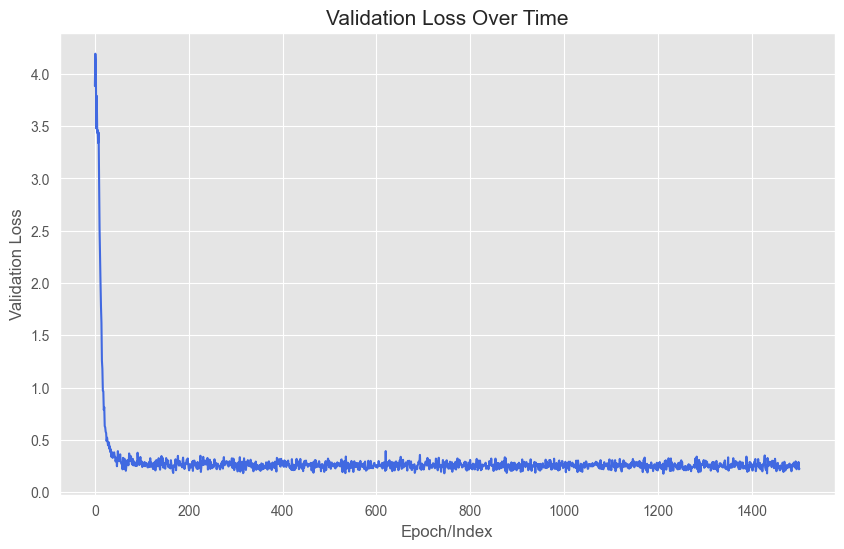

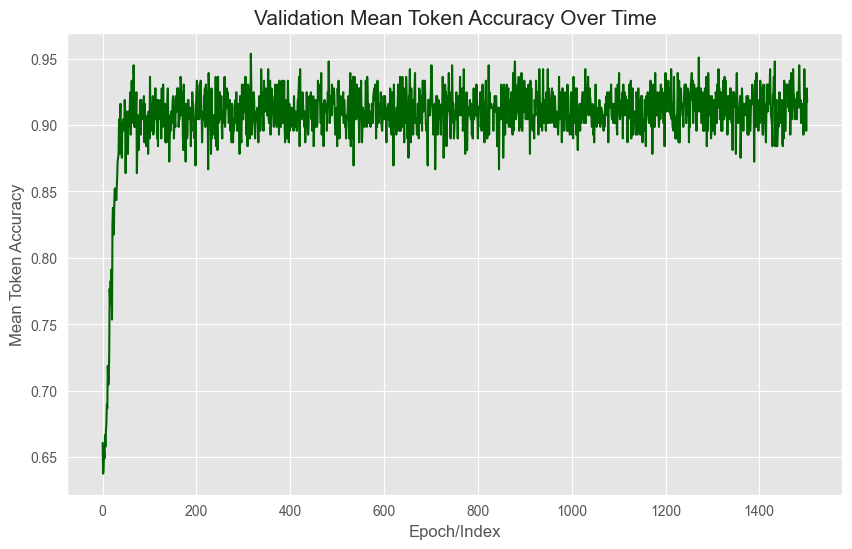

In [248]:
# Plotting the 'valid_loss' values from the 'results_df' DataFrame.
# We drop any NaN values to ensure a smooth plot.
plt.figure(figsize=(10, 6))  # Setting a suitable figure size for better visibility
results_df['train_loss'].dropna().plot(color="royalblue")

# Adding titles and labels for clarity
plt.title('Validation Loss Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)

# Displaying the plot
plt.show()

# Plotting the 'valid_mean_token_accuracy' values from the 'results_df' DataFrame.
# We omit any NaN values to ensure a smooth, continuous plot.
plt.figure(figsize=(10, 6))  # Designating an optimal figure size for better clarity
results_df['train_accuracy'].dropna().plot(color="darkgreen")

# Adding titles and labels for clarity
plt.title('Validation Mean Token Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Mean Token Accuracy', fontsize=12)

# Showcasing the plot
plt.show()


# 3.5 training with a system prompt

In [45]:
# reminder of what this data looks like
json.loads(open("app-review-full-train-sentiment-random-3.5-system.jsonl", "rb").readlines()[0])

{'messages': [{'role': 'system',
   'content': 'You predict star ratings from 0-4 where 0 is the worst rating and 4 is the best'},
  {'role': 'user', 'content': 'Nice😉'},
  {'role': 'assistant', 'content': '4'}]}

In [241]:
training_file_3_5_system = client.files.create(
  file=open("app-review-full-train-sentiment-random-3.5-system.jsonl", "rb"),
  purpose='fine-tune'
)

# Creating a file object for the validation dataset with OpenAI's API.
val_file_3_5_system = client.files.create(
  file=open("app-review-full-val-sentiment-random-3.5-system.jsonl", "rb"),
  purpose='fine-tune'
)

In [49]:
gpt_3_5_with_system_job = client.fine_tuning.jobs.create(
    training_file=training_file_3_5_system.id,
    validation_file=val_file_3_5_system.id,
    model='gpt-3.5-turbo',
    hyperparameters={'n_epochs': 1}
)


In [147]:
gpt_3_5_with_system_job.id

'ftjob-Q88DvA0AYQfOivujvjyR2pFT'

In [152]:
job = client.fine_tuning.jobs.retrieve(gpt_3_5_with_system_job.id)
results_df = None
if len(job.result_files):
    results = client.files.content(job.result_files[0])
        
    # Base64 string (example, replace with your actual string)
    base64_string = results.read()
    
    # Decode the base64 string
    decoded_bytes = base64.b64decode(base64_string)
    decoded_str = decoded_bytes.decode('utf-8')
    
    # Assuming the content is in CSV format, you can write it to a CSV file directly
    with open('results.csv', 'w') as file:
        file.write(decoded_str)
else:
    raise ValueError('Not Done Yet')
results_df = pd.read_csv('results.csv')


In [153]:
results_df.head()

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,1.01825,0.79420,NaN,NaN
1,2,0.89657,0.79710,NaN,NaN
2,3,0.85417,0.80000,NaN,NaN
3,4,0.89545,0.79710,NaN,NaN
4,5,1.10592,0.77971,NaN,NaN


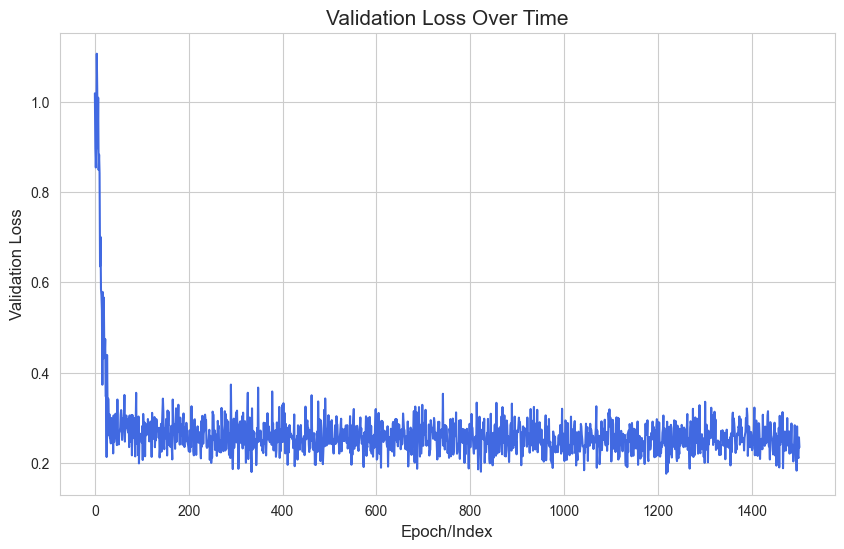

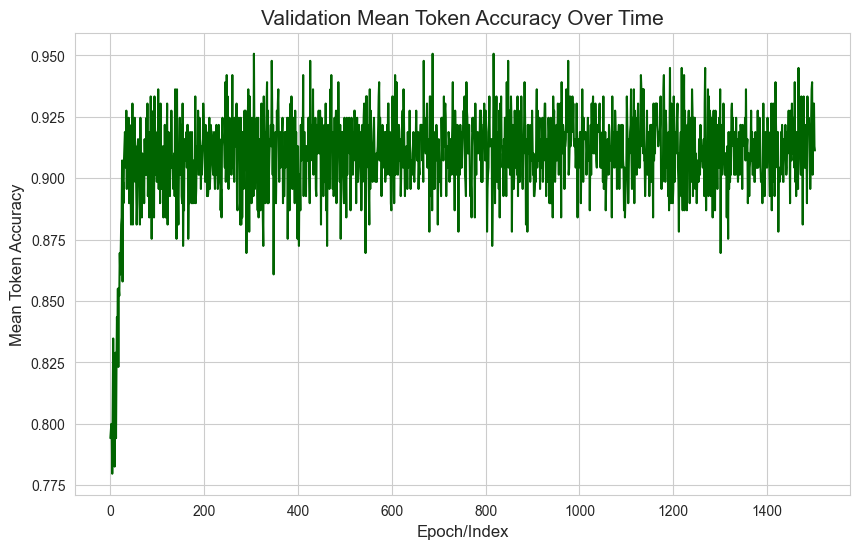

In [154]:
# Plotting the 'valid_loss' values from the 'results_df' DataFrame.
# We drop any NaN values to ensure a smooth plot.
plt.figure(figsize=(10, 6))  # Setting a suitable figure size for better visibility
results_df['train_loss'].dropna().plot(color="royalblue")

# Adding titles and labels for clarity
plt.title('Validation Loss Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)

# Displaying the plot
plt.show()

# Plotting the 'valid_mean_token_accuracy' values from the 'results_df' DataFrame.
# We omit any NaN values to ensure a smooth, continuous plot.
plt.figure(figsize=(10, 6))  # Designating an optimal figure size for better clarity
results_df['train_accuracy'].dropna().plot(color="darkgreen")

# Adding titles and labels for clarity
plt.title('Validation Mean Token Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Mean Token Accuracy', fontsize=12)

# Showcasing the plot
plt.show()


In [155]:
# that mean token accuracy is interesting.. it claims to have a severely low accuracy but as we will see, this is not
#  true according to our testing set.. I frankly am not sure why this reported accuracy is so low

# Evalauting our classifier using test accuracy

In [206]:
# Importing the numpy library to perform mathematical operations
import numpy as np

# Define a function to run the fine-tuned model and get the model's response
def run_ft_model(review, ft_id, system='', chat=False):
    """
    Given a review and a fine-tuned model ID, this function uses OpenAI's Completion API to
    generate a completion. It also calculates the exponential of the top log probabilities for the completion.
    
    Parameters:
    - review (str): The text of the review.
    - ft_id (str): The ID of the fine-tuned model.
    
    Returns:
    - str: The completion generated by the model.
    - dict: A dictionary of tokens and their corresponding exponential of top log probabilities.
    """
    
    # Use OpenAI's API to create a completion using the fine-tuned model
    if chat:
        completion = client.chat.completions.create(
            model=ft_id,
            messages=[
                {"role": "system", "content": system},
                {"role": "user", "content": review}
            ],
            max_tokens=1,
            temperature=0.1,
            logprobs=True,                     # Request the top 5 log probabilities for the completion
            top_logprobs=5
            
        )
        text = completion.choices[0].message.content.strip()
        probs = {t.token: np.exp(t.logprob) for t in completion.choices[0].logprobs.content[0].top_logprobs}
        
        return text, probs
    else:
        completion = client.completions.create(
            model=ft_id,                   # Specify the fine-tuned model ID
            prompt=f'{review}\n###\n',     # Format the review with the prompt structure
            max_tokens=1,                  # Limit the response to 1 token (useful for classification tasks)
            temperature=0.1,               # Set a low temperature for more deterministic output
            logprobs=5                     # Request the top 5 log probabilities for the completion
        )
        
        # Extract the model's completion text and strip any extra whitespace
        text = completion.choices[0].text.strip()
        
        # Convert the log probabilities to regular probabilities using the exponential function
        # This provides a clearer understanding of the model's confidence in its responses
        probs = {k: np.exp(v) for k, v in completion.choices[0].logprobs.top_logprobs[-1].items()}
        
        return text, probs

In [207]:
run_ft_model('i hate it', gpt_3_5_with_system_job.fine_tuned_model, chat=True, system=system_prompt)

('0',
 {'0': 0.8119405465788642,
  '4': 0.09705203509841609,
  '1': 0.051789419879963904,
  '2': 0.026422253190714406,
  '3': 0.012679542640306907})

In [158]:
# Example usage: Predict the sentiment and associated probabilities of the given review using the fine-tuned model
run_ft_model(
    'I hated this thing it was the worst',
    client.fine_tuning.jobs.retrieve(no_system_babbage_job.id).fine_tuned_model
)  # babbage for one epoch

('0',
 {'0': 0.9148366996154271,
  '1': 0.03817410777964789,
  '4': 0.03247224352290873,
  '2': 0.009867273547689607,
  '3': 0.004406479093077916})

In [140]:
# Example usage: Predict the sentiment and associated probabilities of the given review using the fine-tuned model
run_ft_model(
    'I loved this thing it was the best',
    client.fine_tuning.jobs.retrieve(no_system_babbage_job.id).fine_tuned_model
)  # babbage for one epoch

('4',
 {'4': 0.9353676765864467,
  '3': 0.040693374031330116,
  '0': 0.010941974651141145,
  '2': 0.00796228468165402,
  '1': 0.004944474937650051})

In [ ]:
# As of 11/5/2023 - pricing for fine-tuning (https://openai.com/pricing)

#    Model	         Training        	Input usage 	   Output usage
# gpt-3.5-turbo     $8.00 / 1M          $3.00 / 1M          $6.00 / 1M
# babbage-002       $0.40 / 1M          $1.60 / 1M          $1.60 / 1M

In [15]:
pricing = {
    'gpt-3.5-turbo-0125': {'training': 8, 'input': 3, 'output': 6},
    'babbage-002': {'training': .4, 'input': 1.6, 'output': 1.6},
}

In [34]:
def price_info(job):
    job = client.fine_tuning.jobs.retrieve(job.id)
    job.trained_tokens, job.model
    pricing_select = pricing.get(job.model)
    if not pricing_select:
        for k, v in pricing.items():
            if k in job.model:
                pricing_select = pricing[k]
                break
    train_price_usd = pricing_select['training'] * job.trained_tokens / 1_000_000
    print(f'Price to train {job.model} was ${train_price_usd}')
    avg_tokens_per_input = job.trained_tokens / training_df.shape[0]
    # output is always 1 token
    
    avg_inference_price_usd = pricing_select['input'] * (avg_tokens_per_input / 1_000_000) + (pricing_select['output'] / 1_000_000)
    avg_inference_price_usd
    print(f'Price for a single inference (on avg): ${avg_inference_price_usd} and cost to run test: ${avg_inference_price_usd * test_df.shape[0]}')

## Evaluating our models

In [21]:
no_system_babbage_job = client.fine_tuning.jobs.retrieve('ftjob-YKpH6oQ2y4h8eixygIkbfpKl')
no_system_babbage_more_epoch_job = client.fine_tuning.jobs.retrieve('ftjob-FycOYNDnn4jRNOYtzP6qIzJt')
gpt_3_5_no_system_job = client.fine_tuning.jobs.retrieve('ftjob-zYEPB5RONCrCzgGW1P8UhI1U')
gpt_3_5_with_system_job = client.fine_tuning.jobs.retrieve('ftjob-Q88DvA0AYQfOivujvjyR2pFT')

In [132]:
no_system_babbage_job.id, no_system_babbage_more_epoch_job.id, gpt_3_5_no_system_job.id, gpt_3_5_with_system_job.id

('ftjob-YKpH6oQ2y4h8eixygIkbfpKl',
 'ftjob-FycOYNDnn4jRNOYtzP6qIzJt',
 'ftjob-zYEPB5RONCrCzgGW1P8UhI1U',
 'ftjob-Q88DvA0AYQfOivujvjyR2pFT')

In [133]:
price_info(no_system_babbage_job)

Price to train babbage-002 was $1.1334228
Price for a single inference (on avg): $2.7830718761390663e-05 and cost to run test: $1.6034112000000003


In [134]:
price_info(no_system_babbage_more_epoch_job)

Price to train ft:babbage-002:personal::9PVvOEA2 was $3.4002684000000003
Price for a single inference (on avg): $8.029215628417197e-05 and cost to run test: $4.625872


In [211]:
import concurrent.futures
from tqdm.notebook import tqdm
    
# Define the function to process each row
def process_row(job, index, chat=False, system=None):
    row = test_df.iloc[index]
    model_pred, probs = run_ft_model(row.review, job.fine_tuned_model, chat=chat, system=system)
    ground_truth = str(row.star).strip()
    return model_pred

# Define the function to process the DataFrame in parallel
def process_in_batches(job, dataframe, batch_size=10, chat=False, system=None):
    stars_preds = []

    # Use ThreadPoolExecutor to parallelize the processing
    executor = concurrent.futures.ThreadPoolExecutor(max_workers=batch_size)
    try:
        futures = {executor.submit(process_row, job, index, chat, system): index for index in range(dataframe.shape[0])}

        for future in tqdm(concurrent.futures.as_completed(futures), total=dataframe.shape[0], desc="Processing rows"):
            try:
                result = future.result()
                stars_preds.append(result)
                if len(stars_preds) % 1000 == 0:
                    print(len(stars_preds))
            except Exception as e:
                print(f"Error processing row {futures[future]}: {e}")

    finally:
        # Ensure all threads are terminated
        executor.shutdown(wait=True)

    return stars_preds

In [58]:
# Use the function to process your DataFrame
babbage_stars_preds = process_in_batches(no_system_babbage_job, test_df.head(), batch_size=3)

Processing rows:   0%|          | 0/5 [00:00<?, ?it/s]

In [68]:
len(babbage_stars_preds)

57613

In [99]:
def plot_stars_preds(star_preds):
    # Creating the bar plot to show distribution of star ratings given (we hope it matches the train dataset.. it does)
    plt.figure(figsize=(10, 6))  # Setting an appropriate figure size for clearer visualization
    pd.Series(star_preds).value_counts().sort_index().plot(kind='bar', color="mediumseagreen", alpha=0.85)
    
    # Adding titles, labels, and other aesthetics for clarity
    plt.title('Distribution of Predicted Star Ratings', fontsize=16, fontweight='bold')
    plt.xlabel('Star Rating', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=0)  # Ensures that the x-axis labels are horizontal
    plt.tight_layout()
    
    # Displaying the enhanced plot
    plt.show()


In [100]:
def eval_star_preds(star_preds):
    plot_stars_preds(star_preds)
    # Accuracy
    acc = (np.array(star_preds).astype(int) == test_df.head(len(star_preds))['completion'].astype(int)).mean()
    print(f'Accuracy is {acc}')
    # < 3 accuracy
    less_three = ((np.array(star_preds).astype(int) <= 3) == (test_df.head(len(star_preds))['completion'].astype(int) <= 3)).mean()
    print(f'<3 Accuracy is {less_three}')
    # Accuracy (off-by-1)
    off_one = ((np.array(star_preds).astype(int) - test_df.head(len(star_preds))['completion'].astype(int)).abs() <= 1).mean()
    print(f'Off by one Accuracy is {off_one}')
    return acc, less_three, off_one

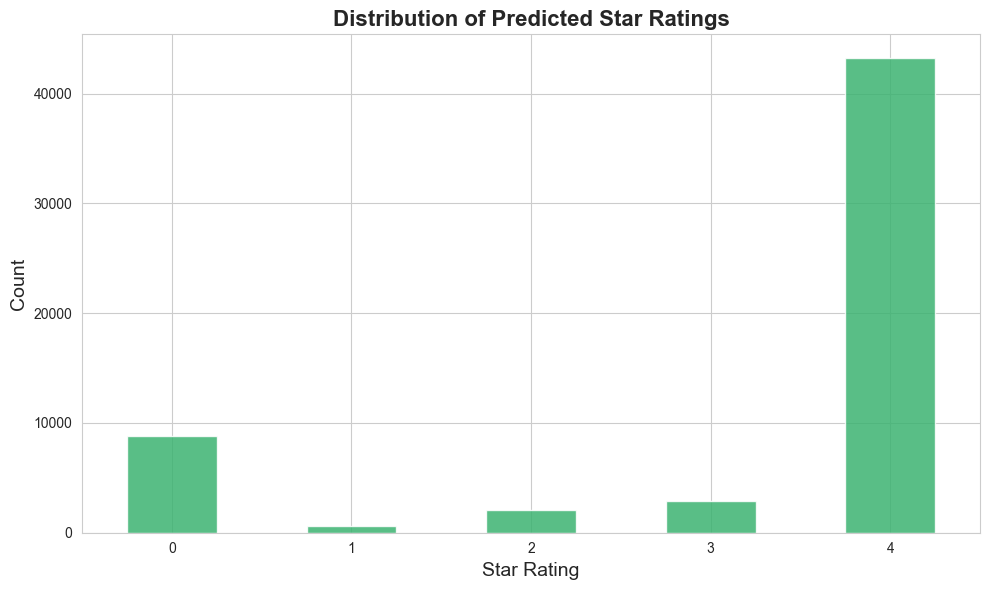

Accuracy is 0.6467637512367
<3 Accuracy is 0.7235519761165015
Off by one Accuracy is 0.7972159061322965


(0.6467637512367, 0.7235519761165015, 0.7972159061322965)

In [101]:
eval_star_preds(babbage_stars_preds)

## comparing against the model that was trained on 4 epoch babbage

In [96]:
# Use the function to process your DataFrame
more_babbage_stars_preds = process_in_batches(no_system_babbage_more_epoch_job, test_df, batch_size=3)

Processing rows:   0%|          | 0/57613 [00:00<?, ?it/s]

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000


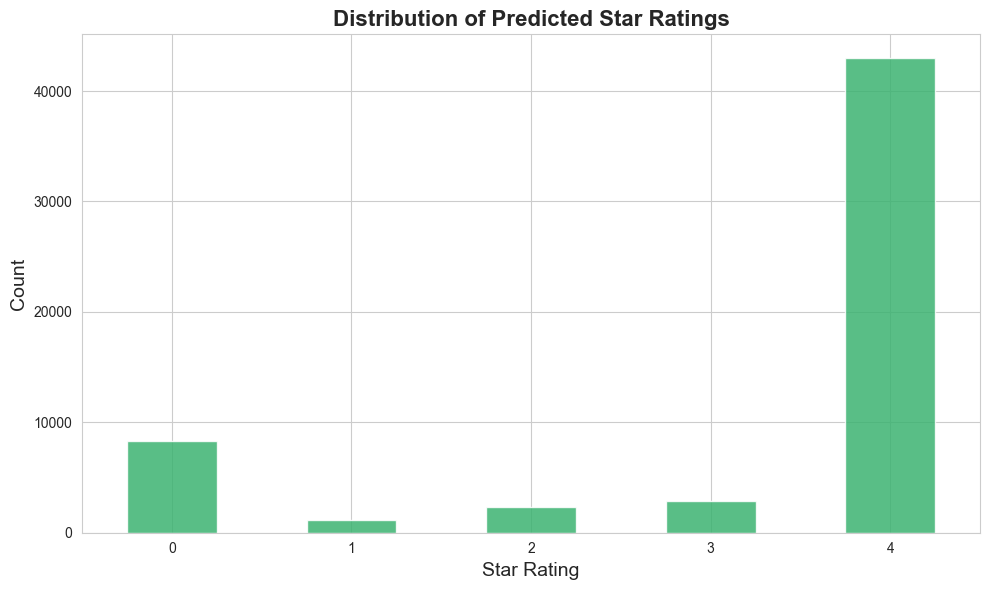

Accuracy is 0.6320795653758701
<3 Accuracy is 0.7109159391109645
Off by one Accuracy is 0.7848055126447157


(0.6320795653758701, 0.7109159391109645, 0.7848055126447157)

In [102]:
eval_star_preds(more_babbage_stars_preds)

In [ ]:
stars_preds = []

# Create a tqdm progress bar
pbar = tqdm(list(range(test_df.shape[0])), total=test_df.shape[0], desc="Processing rows")

# Loop through the dataframe
for index in pbar:
    row = test_df.iloc[index]
    model_pred, probs = run_ft_model(row.review, 'ft:babbage-002:personal::8EKVvxZv')
    ground_truth = str(row.star).strip()
    stars_preds.append(model_pred)
    if index % 1_000 == 0:
        print(index)


In [434]:
# Accuracy
print((np.array(stars_preds).astype(int) == test_df.head(len(stars_preds))['completion'].astype(int)).mean())

# < 3 accuracy
print(((np.array(stars_preds).astype(int) <= 3) == (test_df.head(len(stars_preds))['completion'].astype(int) <= 3)).mean())

# Accuracy (off-by-1)
print(((np.array(stars_preds).astype(int) - test_df.head(len(stars_preds))['completion'].astype(int)).abs() <= 1).mean())

0.7197854650860049
0.8088625830975648
0.881103223230868


In [535]:
train_price_usd = 0.008 * job.trained_tokens / 1_000
print(f'Price to train was ${train_price_usd}')

avg_tokens_per_input = job.trained_tokens / training_df.shape[0]
# output is always 1 token

avg_inference_price_usd = 0.0120 * (avg_tokens_per_input / 1_000) + (0.0160 / 1_000)
avg_inference_price_usd
print(f'Price for a single inference (on avg): ${avg_inference_price_usd} and cost to run test: ${avg_inference_price_usd * test_df.shape[0]}')

Price to train was $39.883296
Price for a single inference (on avg): $0.00036213104681235143 and cost to run test: $20.863456000000003


# 3.5 training - no system prompt

In [252]:
price_info(gpt_3_5_no_system_job)

Price to train gpt-3.5-turbo-0125 was $39.883296
Price for a single inference (on avg): $9.253276170308785e-05 and cost to run test: $5.3310900000000006


In [259]:
# Use the function to process your DataFrame
stars_preds_3_5_no_system = process_in_batches(gpt_3_5_no_system_job, test_df, batch_size=3, chat=True, system='')

Processing rows:   0%|          | 0/57613 [00:00<?, ?it/s]

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000


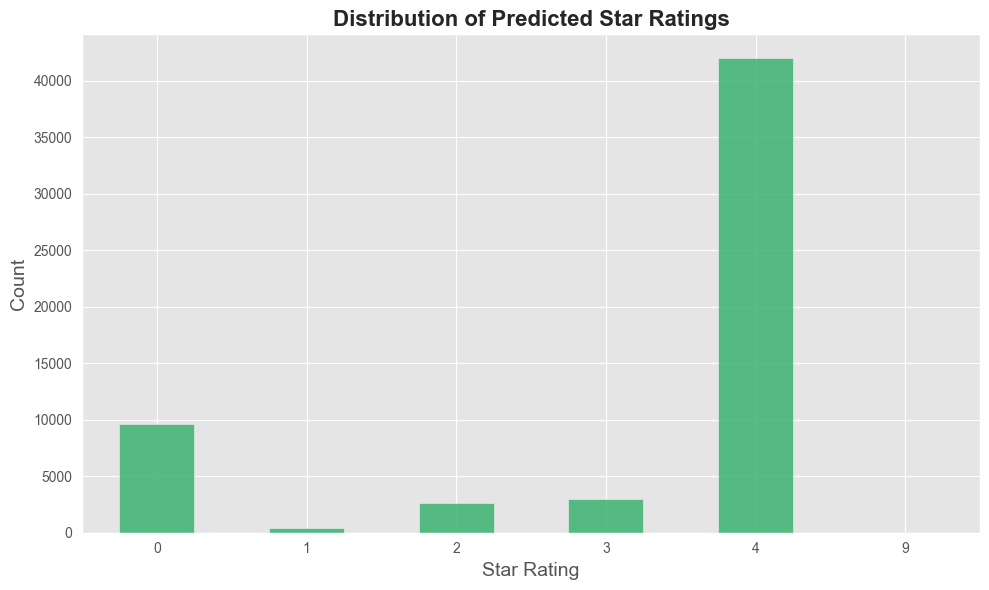

Accuracy is 0.6345442868796973
<3 Accuracy is 0.7146130213667055
Off by one Accuracy is 0.7847534410636489


(0.6345442868796973, 0.7146130213667055, 0.7847534410636489)

In [260]:
eval_star_preds(stars_preds_3_5_no_system)

# 3.5 training - with system prompt

In [135]:
price_info(gpt_3_5_with_system_job)

Price to train gpt-3.5-turbo-0125 was $70.30296
Price for a single inference (on avg): $0.00015853276170308786 and cost to run test: $9.133548000000001


In [220]:
# Use the function to process your DataFrame
stars_preds_3_5_system = process_in_batches(gpt_3_5_with_system_job, test_df, batch_size=3, chat=True, system=system_prompt)

Processing rows:   0%|          | 0/57613 [00:00<?, ?it/s]

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000


In [221]:
len(stars_preds_3_5_system)

57613

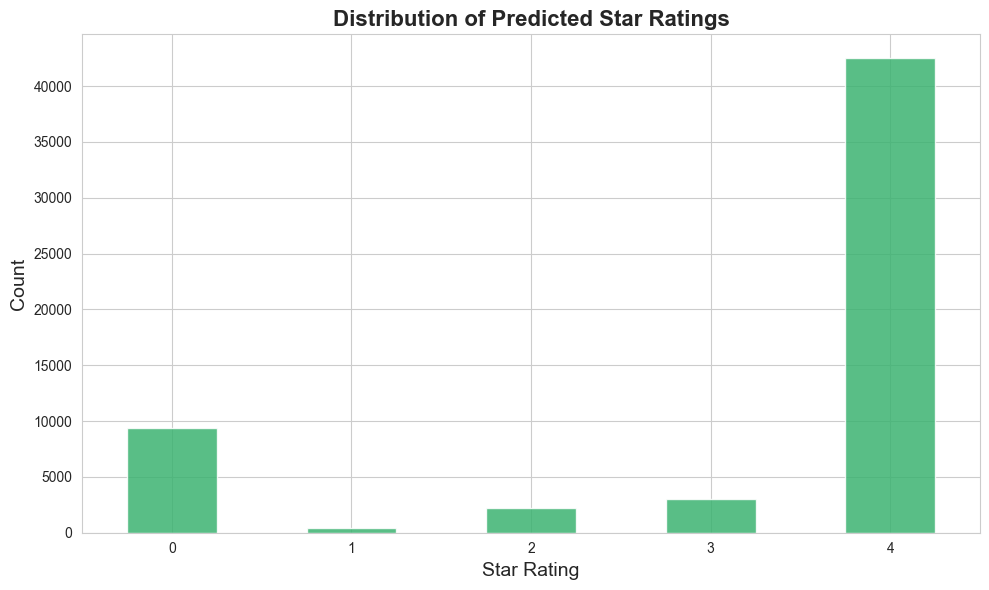

Accuracy is 0.6442296009581171
<3 Accuracy is 0.7213302553243192
Off by one Accuracy is 0.7951156856959367


(0.6442296009581171, 0.7213302553243192, 0.7951156856959367)

In [222]:
eval_star_preds(stars_preds_3_5_system)

In [1]:
import pandas as pd
# Create a dictionary with your data

data = {
    'Model Description': [
        'Babbage - 1 epoch',
        'Babbage - 4 epochs',
        '3.5 - 1 epoch + no system prompt',
        '3.5 - 1 epoch + system prompt',
        # 'DistilBERT'
    ],
    'Raw Accuracy': [
        0.6467637512367,
        0.6320795653758701,
        0.6345442868796973,
        0.6442296009581171,
        # 0.7138840192317706
    ],
    'Good vs Bad Accuracy': [
        0.7235519761165015,
        0.7109159391109645,
        0.7146130213667055,
        0.7213302553243192,
        # 0.7962091888983389
    ],
    'One-off Accuracy': [
        0.7972159061322965,
        0.7848055126447157,
        0.7847534410636489,
        0.7951156856959367,
        # 0.868033256383108
    ],
    'Cost to Fine-tune (USD)': [
        1.1334228,
        3.4002684000000003+1.1334228,
        39.883296,
        70.30296,
        # 0.6
    ],
    'Cost for a Single Inference (USD)': [
        2.7830718761390663e-05,
        2.7830718761390663e-05,
        9.253276170308785e-05,
        0.0007341310468123514,
        # 0.000001
    ],
    'Cost to Run Evaluation on Test Set (USD)': [
        1.6034112,
        1.6034112,
        5.33109,
        9.133548,
        # 0.05
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# To make it more readable, let's round the numeric values to a fixed number of decimal places:
df_rounded = df.round(5)
df_rounded

,Model Description,Raw Accuracy,Good vs Bad Accuracy,One-off Accuracy,Cost to Fine-tune (USD),Cost for a Single Inference (USD),Cost to Run Evaluation on Test Set (USD)
0,Babbage - 1 epoch,0.64676,0.72355,0.79722,1.13342,0.00003,1.60341
1,Babbage - 4 epochs,0.63208,0.71092,0.78481,4.53369,0.00003,1.60341
2,3.5 - 1 epoch + no system prompt,0.63454,0.71461,0.78475,39.88330,0.00009,5.33109
3,3.5 - 1 epoch + system prompt,0.64423,0.72133,0.79512,70.30296,0.00073,9.13355


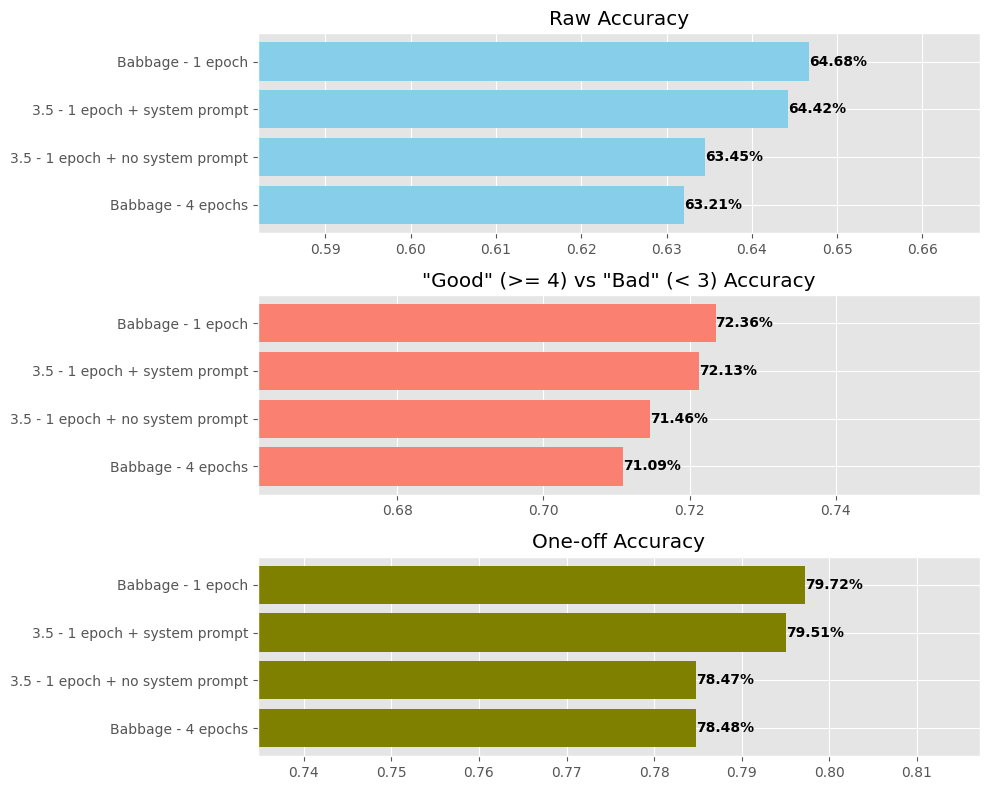

In [2]:
import matplotlib.pyplot as plt

# Find the minimum accuracy values for setting xlim
min_raw_accuracy = min(df_rounded['Raw Accuracy']) - 0.05
max_raw_accuracy = max(df_rounded['Raw Accuracy']) + .02
min_good_bad_accuracy = min(df_rounded['Good vs Bad Accuracy']) - 0.05
max_good_bad_accuracy = max(df_rounded['Good vs Bad Accuracy']) + .02
min_one_off_accuracy = min(df_rounded['One-off Accuracy']) - 0.05
max_one_off_accuracy = max(df_rounded['One-off Accuracy']) + .02

# Set the style
plt.style.use('ggplot')

# Define figure and axes for the accuracy subplots
fig_accuracy, axs_accuracy = plt.subplots(3, 1, figsize=(10, 8))  # Adjust the figure size as needed

df_rounded.sort_values('Raw Accuracy', inplace=True, ascending=True)

axs_accuracy[0].barh(df_rounded['Model Description'], df_rounded['Raw Accuracy'], color='skyblue')
axs_accuracy[0].set_title('Raw Accuracy')
axs_accuracy[0].set_xlim(min_raw_accuracy, max_raw_accuracy)  # Extend the x-axis
for i, v in enumerate(df_rounded['Raw Accuracy']):
    axs_accuracy[0].text(v, i, "{:,.2f}%".format(v * 100), va='center', ha='left', fontweight='bold')

# Plot for Good vs Bad Accuracy
axs_accuracy[1].barh(df_rounded['Model Description'], df_rounded['Good vs Bad Accuracy'], color='salmon')
axs_accuracy[1].set_title('"Good" (>= 4) vs "Bad" (< 3) Accuracy')
axs_accuracy[1].set_xlim(min_good_bad_accuracy, )  # Extend the x-axis
for i, v in enumerate(df_rounded['Good vs Bad Accuracy']):
    axs_accuracy[1].text(v, i, "{:,.2f}%".format(v * 100), va='center', ha='left', fontweight='bold')
    
# Plot for One-off Accuracy
axs_accuracy[2].barh(df_rounded['Model Description'], df_rounded['One-off Accuracy'], color='olive')
axs_accuracy[2].set_title('One-off Accuracy')
axs_accuracy[2].set_xlim(min_one_off_accuracy, max_one_off_accuracy)  # Extend the x-axis
for i, v in enumerate(df_rounded['One-off Accuracy']):
    axs_accuracy[2].text(v, i, "{:,.2f}%".format(v * 100), va='center', ha='left', fontweight='bold')
    
# Adjust the layout
plt.tight_layout()

# Show the plot for accuracies
plt.show()

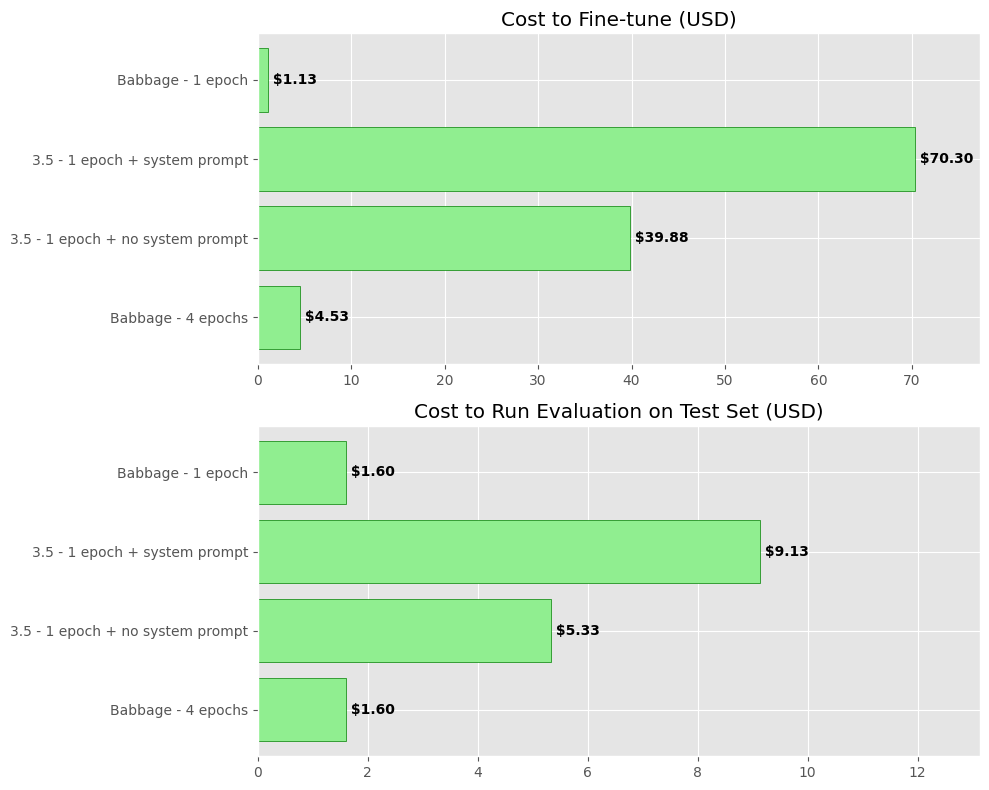

In [3]:
# Set the style
plt.style.use('ggplot')

max_fine_tune = max(df_rounded['Cost to Fine-tune (USD)']) + 7
max_eval = max(df_rounded['Cost to Run Evaluation on Test Set (USD)']) + 4

# Define figure and axes for the cost subplots
fig_cost, axs_cost = plt.subplots(2, 1, figsize=(10, 8))  # Adjust the figure size as needed

# Use a lighter green and specify a custom edgecolor for a bolder look
light_green_color = '#90ee90'  # Light green color code

# Plot for Cost to Fine-tune
axs_cost[0].barh(df_rounded['Model Description'], df_rounded['Cost to Fine-tune (USD)'], color=light_green_color, edgecolor='green')
axs_cost[0].set_title('Cost to Fine-tune (USD)')
axs_cost[0].set_xlim(0, max_fine_tune)  # Extend the x-axis

# Annotate with bold text
for i, v in enumerate(df_rounded['Cost to Fine-tune (USD)']):
    axs_cost[0].text(v, i, " ${:,.2f}".format(v), va='center', ha='left', fontweight='bold')

# Plot for Cost to Run Evaluation on Test Set
axs_cost[1].barh(df_rounded['Model Description'], df_rounded['Cost to Run Evaluation on Test Set (USD)'], color=light_green_color, edgecolor='green')
axs_cost[1].set_title('Cost to Run Evaluation on Test Set (USD)')
axs_cost[1].set_xlim(0, max_eval)  # Extend the x-axis

# Annotate with bold text
for i, v in enumerate(df_rounded['Cost to Run Evaluation on Test Set (USD)']):
    axs_cost[1].text(v, i, " ${:,.2f}".format(v), va='center', ha='left', fontweight='bold')

# Adjust the layout
plt.tight_layout()

# Show the plot for costs
plt.show()


# Using our model in the playground

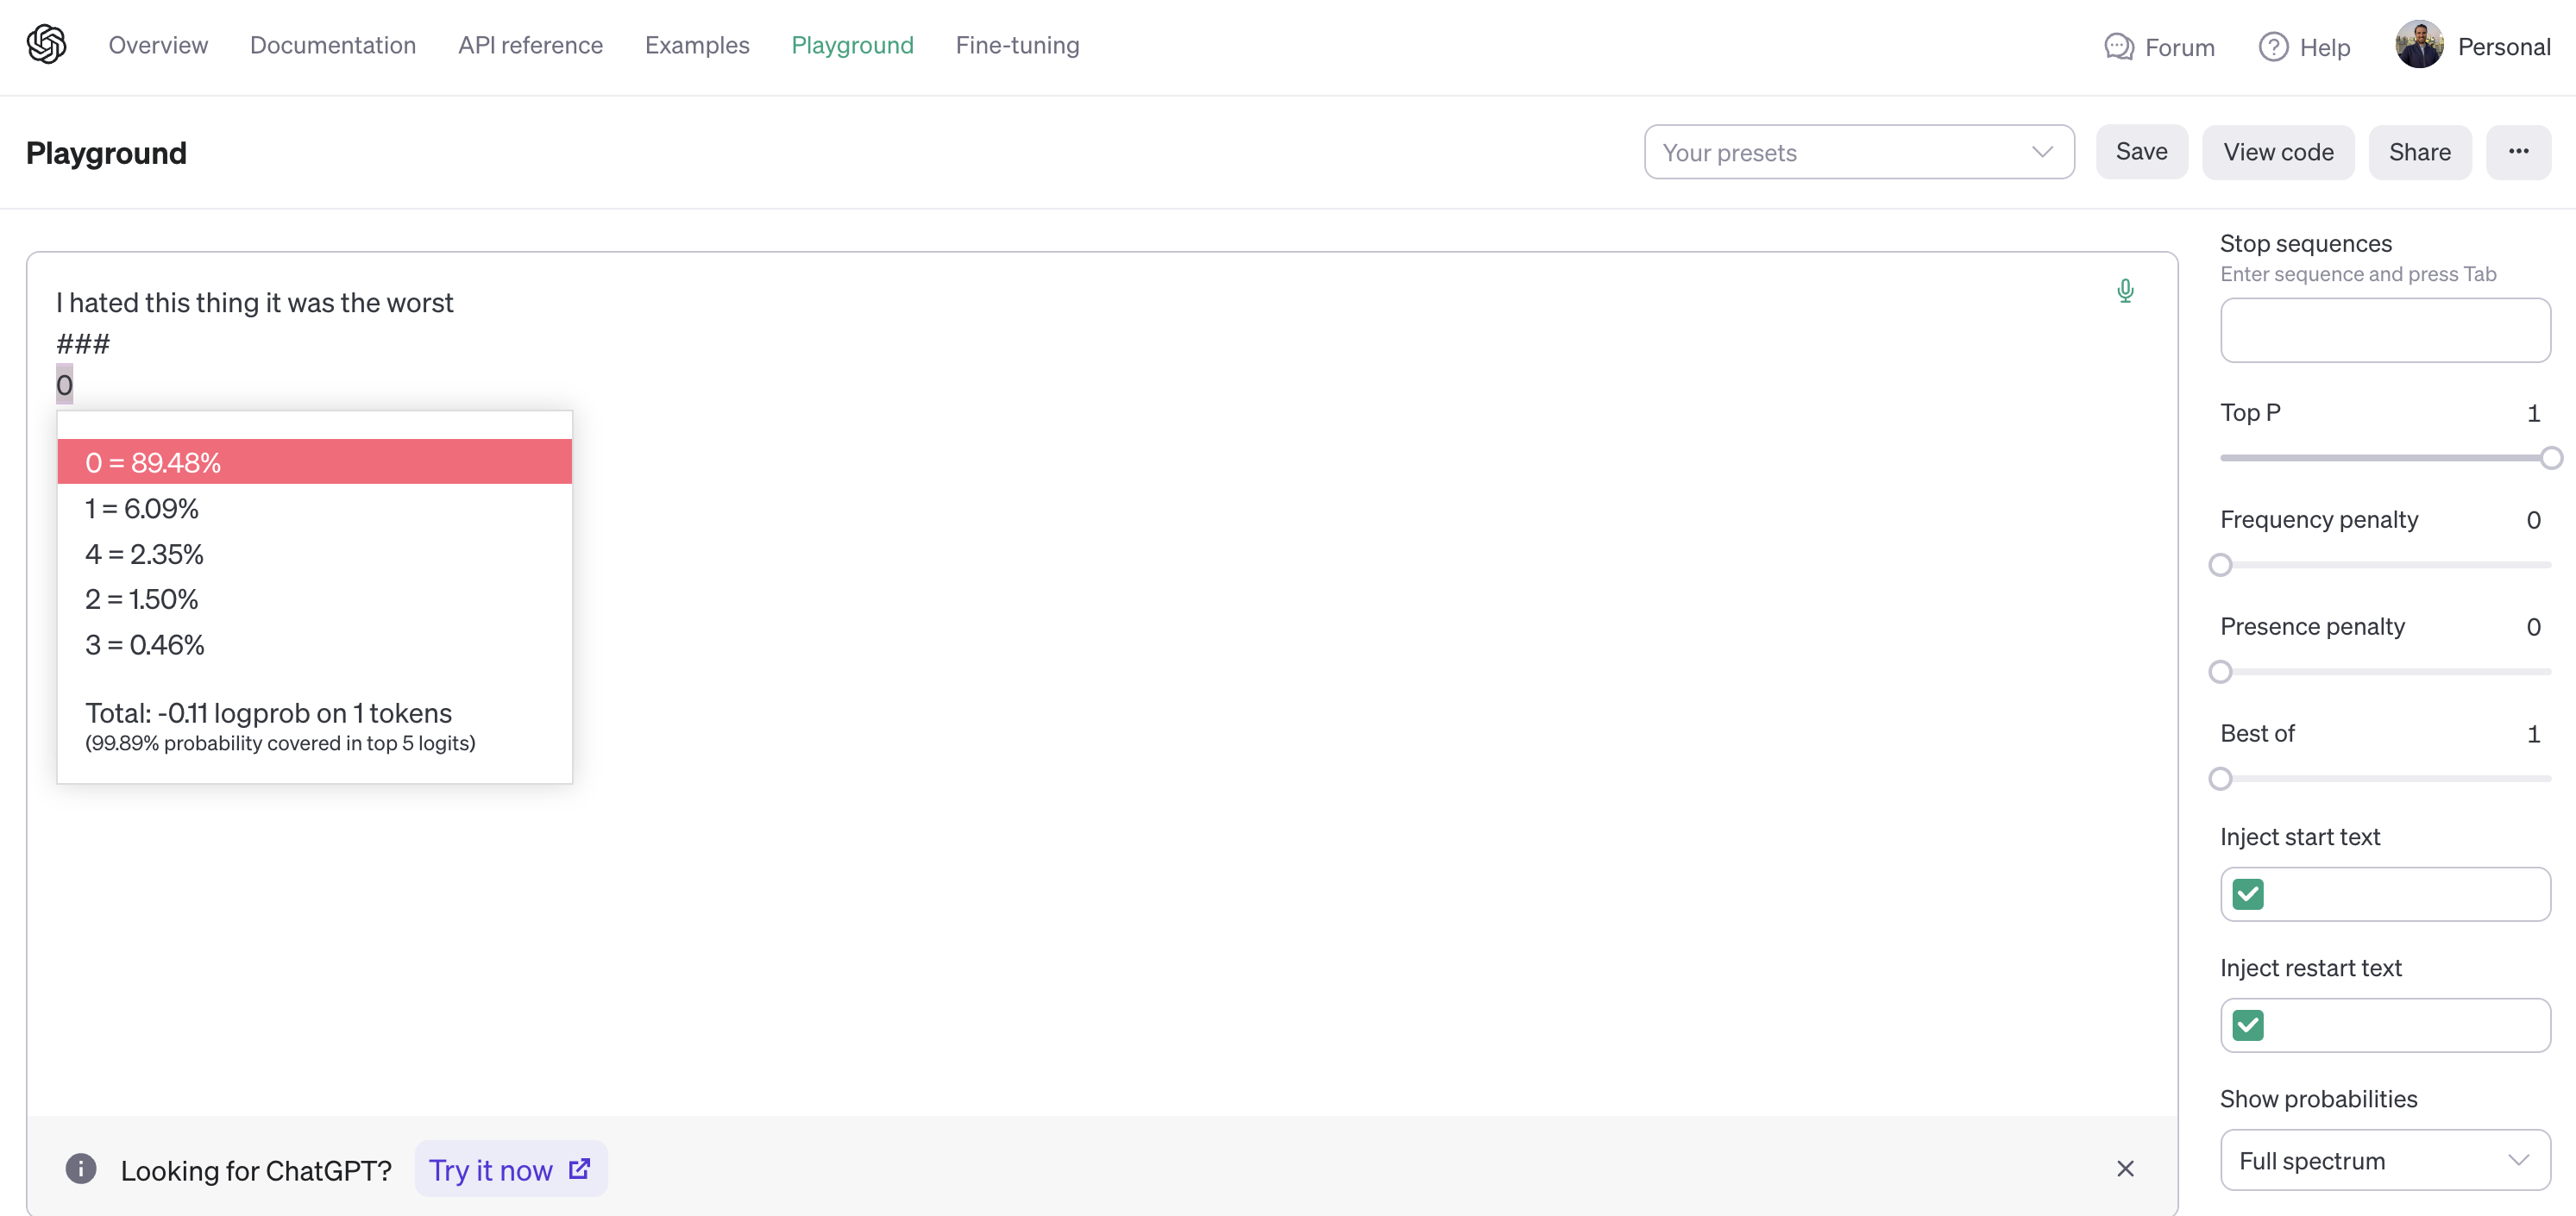